In [0]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Reading files
###Orderbook File:		(Matrix of size: (Nx(4xNumberOfLevels)))

	
Columns:

1. Ask Price 1: 	Level 1 Ask Price 	(Best Ask)
2. Ask Size 1: 	Level 1 Ask Volume 	(Best Ask Volume)
3. Bid Price 1: 	Level 1 Bid Price 	(Best Bid)
4. Bid Size 1: 	Level 1 Bid Volume 	(Best Bid Volume)
5. Ask Price 2: 	Level 2 Ask Price 	(2nd Best Ask)
6. ...


###Message File:		(Matrix of size: (Nx6))
		
  StartTime and EndTime give the theoretical beginning 
  and end time of the output file in milliseconds after 		
  mid night. LEVEL refers to the number of levels of the 
  requested limit order book.


Columns:

1. Time: Seconds after midnight with decimal precision of at least milliseconds and up to nanoseconds depending on the requested period
2. Type:
  * 1: Submission of a new limit order
  * 2: Cancellation (Partial deletion of a limit order)
  * 3: Deletion (Total deletion of a limit order)
  * 4: Execution of a visible limit order			   	 
  * 5: Execution of a hidden limit order
  * 7: Trading halt indicator (Detailed information below)
3. Order ID: Unique order reference number (Assigned in order flow)
4. Size: Number of shares
5. Price: Dollar price times 10000 (i.e., A stock price of $91.14 is given by 911400)
6. Direction:
  * -1: Sell limit order
  * 1: Buy limit order
  
Note: 
Execution of a sell (buy) limit order corresponds to a buyer (seller) initiated trade, i.e. Buy (Sell) trade.

In [0]:
message_file_10 = 'MSFT_2012-06-21_34200000_57600000_message_10.csv'
orderbook_file_10 = 'MSFT_2012-06-21_34200000_57600000_orderbook_10.csv'


In [0]:
'''
ob = pd.read_csv(orderbook_file_10, header=None)
print(ob.shape)
ob.head()
'''

'\nob = pd.read_csv(orderbook_file_10, header=None)\nprint(ob.shape)\nob.head()\n'

In [0]:
mesg = pd.read_csv(message_file_10, header=None, names=['Time', 'Type', 'Order_id', 'Size', 'Price', 'Direction'])


Getting OHLCV from trades
---------------------------


In [0]:
def _get_ohlcv(group):
  return {'Time': group['Time'].iloc[0],
          'Open': group['Price'].iloc[0], 
          'High': np.max(group['Price']), 
          'Low': np.min(group['Price']), 
          'Close': group['Price'].iloc[-1], 
          'Volume': np.sum(group['Size'])}
  

def ob_to_ohlcv(messages, timewindow=1):
  '''
  function to transform limit order book ticks to OHLCV ticks
    timewindow, integer: number of seconds for OHLCV's timeframes
  '''
  result = messages.copy()
  result = result[(result['Type'] == 4) | (result['Type'] == 5)]
  result = result.groupby(np.floor(result['Time'] / timewindow), as_index=False)
  result = result.apply(_get_ohlcv).apply(pd.Series)

  # add missing seconds
  first_second = int(np.floor(result['Time'].iloc[0]))
  last_second = int(np.ceil(result['Time'].iloc[-1]))
  for idx in range(last_second - first_second):
    cur_sec = int(np.floor(result['Time'].iloc[idx]))
    if cur_sec != first_second + idx: # then it's a missing second
      add_line = result.iloc[[idx]].copy()
      add_line['Time'] = first_second + idx
      result = pd.concat([result.iloc[:idx], add_line, result.iloc[idx:]], ignore_index=True)

  return result


In [0]:
ohlcv = ob_to_ohlcv(mesg, timewindow=1)

Pump-and-dump detection
-------------------------
* In 5-sec window (or 10, or whatever)

In [0]:
# -1 sell, 1 buy
mesg.head()

,Time,Type,Order_id,Size,Price,Direction
0,34200.013994,3,16085616,100,310400,-1
1,34200.013994,1,16116348,100,310500,-1
2,34200.015248,1,16116658,100,310400,-1
3,34200.015442,1,16116704,100,310500,-1
4,34200.015789,1,16116752,100,310600,-1


In [0]:
def heuristic(messages, time_start, timewindow):
  group = messages[(messages['Time'] >= time_start) & (messages['Time'] < time_start + timewindow)]
  n_third = group.shape[0] // 3
  part_1 = group.iloc[:n_third, :]
  part_2 = group.iloc[n_third:n_third*2, :]
  part_3 = group.iloc[n_third*2:, :]

  # pumping: increase in price
  threshold_1 = 0.002
  p_matched_min_buy =  part_1[((part_1['Type'] == 4) | (part_1['Type'] == 5)) & (part_1['Direction'] == 1)]['Price'].min()
  p_matched_max_buy =  part_2[((part_2['Type'] == 4) | (part_2['Type'] == 5)) & (part_2['Direction'] == 1)]['Price'].max()
  pump = (p_matched_max_buy - p_matched_min_buy) > (p_matched_max_buy * threshold_1)


  # dumping: decrease in price
  threshold_2 = 0.002
  p_matched_max_sell = part_2[((part_2['Type'] == 4) | (part_2['Type'] == 5)) & (part_2['Direction'] == -1)]['Price'].max()
  p_matched_min_sell = part_3[((part_3['Type'] == 4) | (part_3['Type'] == 5)) & (part_3['Direction'] == -1)]['Price'].min()
  dump_1 = (p_matched_max_sell - p_matched_min_sell) > (p_matched_max_sell * threshold_2)
  
  # dumping: many canceled orders
  threshold_3 = 0.4
  v_cancelled_buy =    part_2[((part_2['Type'] == 2) | (part_2['Type'] == 3)) & (part_2['Direction'] == 1)]['Size'].sum()
  v_matched_buy_mean = part_2[((part_2['Type'] == 4) | (part_2['Type'] == 5)) & (part_2['Direction'] == 1)]['Size'].mean()
  dump_2 = v_cancelled_buy > (v_matched_buy_mean * threshold_3)

  return {'dump_1': dump_1, 'dump_2': dump_2, 'pump': pump, 'pump&dump': dump_1 & dump_2 & pump}


In [0]:

def label_data(messages, timewindow=60):
  '''
  get labeled data from trades' flow
  it's a sliding window, kind of -- sliding over seconds even if there are many ticks in one second
  '''
  parts = 3
  shift = timewindow // parts
  shifted_messages = messages.copy()
  shifted_messages['Time'] = np.floor(shifted_messages['Time'] / shift)  # sliding window by 20 second
  first_second = int(np.floor(shifted_messages['Time'].iloc[0]))
  last_second = int(np.ceil(shifted_messages['Time'].iloc[-1]))
  result = pd.DataFrame({'Time': list(range(first_second, last_second - parts + 1))})
  result['Label'] = result.apply(lambda x: heuristic(shifted_messages, x['Time'], parts), axis=1)
  result = result['Label'].apply(pd.Series)
  result['Time'] = list(range(first_second, last_second - parts + 1))

  return result

In [0]:
%time labeled = label_data(mesg)

NN training
-----------

##Prepare data
Get OHLCV data, stack it `n` times and add a label. That would be our training dataset.

In [0]:
def stack_seconds(ohlcv, timeframe=60):
  eps=1
  ohlcv_cleaned = ohlcv.copy().drop(columns=['Time'])
  ohlcv_cleaned['Log_Volume'] = np.log(ohlcv_cleaned.pop('Volume') + eps)
  ohlcv_cleaned['Log_Open'] = np.log(ohlcv_cleaned.pop('Open') + eps)
  ohlcv_cleaned['Log_High'] = np.log(ohlcv_cleaned.pop('High') + eps)
  ohlcv_cleaned['Log_Low'] = np.log(ohlcv_cleaned.pop('Low') + eps)
  ohlcv_cleaned['Log_Close'] = np.log(ohlcv_cleaned.pop('Close') + eps)
  result = ohlcv_cleaned.copy().add_suffix("_0")
  for sec in range(1, timeframe):
    result = result.join(ohlcv_cleaned.iloc[sec:,].copy().reset_index(drop=True).add_suffix("_{}".format(sec)))
  result = result.drop(result.tail(timeframe-1).index)
  return result

In [0]:
ohlcv_stacked = stack_seconds(ohlcv)

In [0]:
neg, pos = np.bincount(target)
total = neg + pos

In [0]:
features = ohlcv_stacked.to_numpy()

##Compare models and stuff

Basically it's the same code from above but only relevant block are kept so it's easier and quicker to change things.

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [0]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
RANDOM_SEED = 4242
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

###Prepare data

In [0]:
BUFFER_SIZE = 100000
EPOCHS = 100
BATCH_SIZE = 2048

In [0]:
features_labeled_df = ohlcv_stacked.copy()
features_labeled_df['Label'] = target

train_df, test_df = train_test_split(features_labeled_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Label'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Label'))
test_labels = np.array(test_df.pop('Label'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)



pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)




weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

### Plot functions

In [0]:
def plot_metrics(history):
  metrics =  ['loss', 'pr_auc']#, 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [0]:
def plot_pr(name, labels, predictions, title, **kwargs):
  # set design stuff
  ax = plt.subplot(111)#, figsize=(12,12))    
  ax.spines["top"].set_visible(False)   
  ax.spines["right"].set_visible(False)
  plt.grid(True, color="#93a1a1", alpha=0.3)
  
  # actual plot 
  precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

  plt.plot(100*recall, 100*precision, label=name, linewidth=2, **kwargs)
  ax.set_xlabel('Recall [%]', labelpad=15, fontsize=12, color="#333533")
  ax.set_ylabel('Precision [%]', labelpad=15, fontsize=12, color="#333533")
  ax.set_title("Precision-Recall Curve for {}".format(title), fontsize=18, color="#333533")
  ax.set_xlim([-0.5,100.5])
  ax.set_ylim([-0.5,100.5])
  #plt.grid(True)
  #ax = plt.gca()
  ax.set_aspect('equal')

###Set model

In [0]:
def run_default_weigthed_oversampled(make_model, early_stopping=early_stopping_baseline):
  # inital weights
  initial_bias = np.log([pos/neg])
  model = make_model(output_bias = initial_bias)
  model.predict(train_features[:10])
  initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
  model.save_weights(initial_weights)

  # default
  model = make_model()
  model.load_weights(initial_weights)

  baseline_history = model.fit(
      train_features,
      train_labels,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks = [early_stopping],
      validation_data=(val_features, val_labels),
      verbose=0)
  
  # weighted
  weighted_model = make_model()
  weighted_model.load_weights(initial_weights)

  weighted_history = weighted_model.fit(
      train_features,
      train_labels,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks = [early_stopping],
      validation_data=(val_features, val_labels),
      class_weight=class_weight,
      verbose=0) 
  
  # oversampled
  resampled_model = make_model()
  resampled_model.load_weights(initial_weights)

  output_layer = resampled_model.layers[-1] 
  output_layer.bias.assign([0])

  val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
  val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

  resampled_history = resampled_model.fit(
      resampled_ds,
      steps_per_epoch = 20,
      epochs=10*EPOCHS,
      callbacks = [early_stopping],
      validation_data=(val_ds),
      verbose=0)

  return model, weighted_model, resampled_model

In [0]:
def draw_stuff(model, weighted_model, resampled_model, title):
  train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
  test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)
  train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
  test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
  train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
  test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

  '''
  plot_roc("Train Imbalanced", train_labels, train_predictions_baseline, color=colors[0])
  plot_roc("Test Imbalanced", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

  plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
  plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

  plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
  plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
  plt.legend(loc='lower right')
  plt.show()
  '''

  plot_pr("Train Imbalanced", train_labels, train_predictions_baseline, title, color=colors[0])
  plot_pr("Test Imbalanced", test_labels, test_predictions_baseline, title, color=colors[0], linestyle='--')

  plot_pr("Train Weighted", train_labels, train_predictions_weighted, title, color=colors[1])
  plot_pr("Test Weighted", test_labels, test_predictions_weighted, title, color=colors[1], linestyle='--')

  plot_pr("Train Resampled", train_labels, train_predictions_resampled,  title, color=colors[2])
  plot_pr("Test Resampled", test_labels, test_predictions_resampled,  title, color=colors[2], linestyle='--')
  plt.legend(loc='lower left')
  #plt.title("Precision-Recall Curve for {}".format(title))
  plt.show()

  print("Default model:")
  default_results = model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
  for name, value in zip(model.metrics_names, default_results):
    print(name, ': ', value)
  print()

  print("Weighted model:")
  weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
  for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
  print()

  print("Resampled model")
  resampled_results = resampled_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
  for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
  print()

In [0]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(curve='PR', name='pr_auc'),
]

In [0]:
'''
just copy of a blocj i used all this time
'''
def make_model_old(output_bias=None):
  metrics = [
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(curve='PR', name='pr_auc'),
            ]
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  # 256-128-64 pretty good result
  # 32-16-8 even better, bc it doesn't look as if it's overfitting
  # 256-64-16 best so far
  # or 256-64
  model = keras.Sequential([
                            keras.layers.Dense(256,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.5),

                            
                            #keras.layers.Dense(128,
                            #                   activation='relu',
                            #                   ),
                            #keras.layers.BatchNormalization(),
                            #keras.layers.Dropout(0.5),
                            
                            keras.layers.Dense(64,
                                               activation='relu'),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.5),

                            keras.layers.Dense(1,
                                               activation='sigmoid',
                                               bias_initializer=output_bias),
                            ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

early_stopping_old = tf.keras.callbacks.EarlyStopping(
    monitor='val_pr_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [0]:
early_stopping_baseline = tf.keras.callbacks.EarlyStopping(
    monitor='val_pr_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

#### baseline model

In [0]:
'''
One hidden layer with 32 nodes, only pr-auc
'''
def make_model_baseline(output_bias=None):
  metrics = [
             keras.metrics.AUC(curve='PR', name='pr_auc'),
            ]
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
                            keras.layers.Dense(512,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            
                            keras.layers.Dense(256,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            
                            keras.layers.Dense(128,
                                               activation='relu',
                                               ),

                            keras.layers.Dense(32,
                                               activation='relu',
                                               ),

                            keras.layers.Dense(16,
                                               activation='relu',
                                               ), 
                            
                            keras.layers.Dense(1,
                                               activation='sigmoid',
                                               bias_initializer=output_bias),
                            ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [0]:
baseline_models = run_default_weigthed_oversampled(make_model_baseline)

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

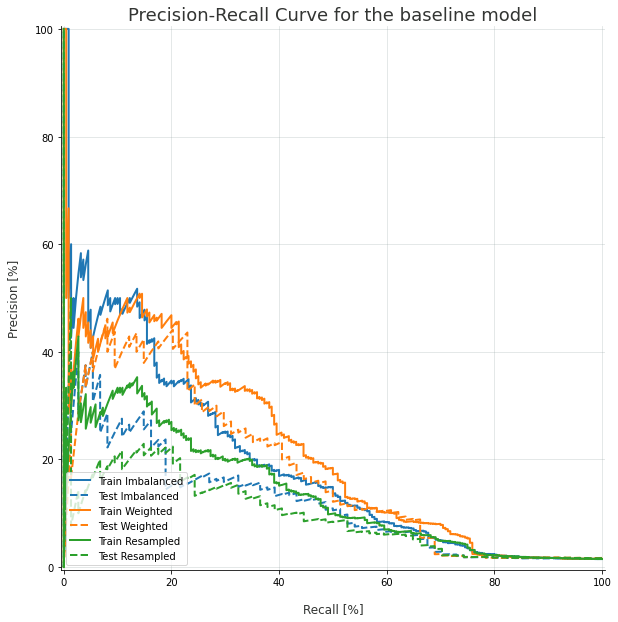

Default model:
loss :  0.075640007853508
pr_auc :  0.11522433906793594

Weighted model:
loss :  0.364929735660553
pr_auc :  0.1747761219739914

Resampled model
loss :  0.8856476545333862
pr_auc :  0.0908767357468605



In [0]:
draw_stuff(*baseline_models, "the baseline model")

####baseline with dropout and banchnorm

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

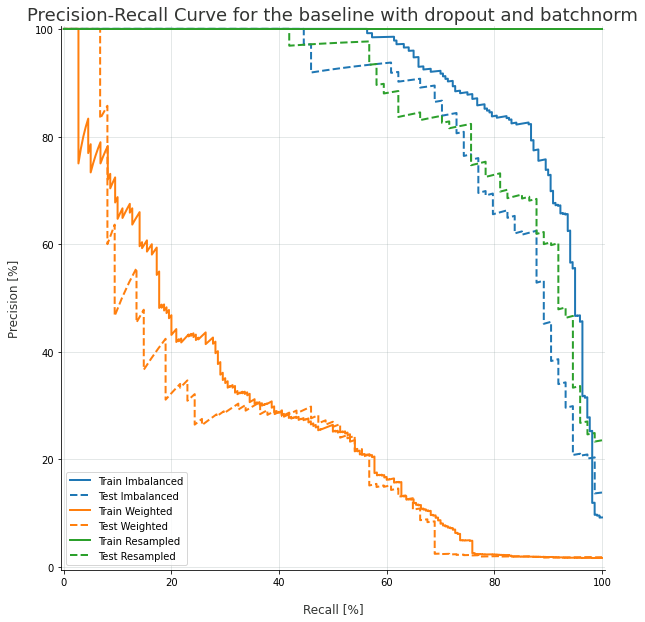

Default model:
loss :  0.036892231553792953
pr_auc :  0.8423577547073364

Weighted model:
loss :  0.14291301369667053
pr_auc :  0.2567366659641266

Resampled model
loss :  0.021184802055358887
pr_auc :  0.8572919368743896



In [0]:
'''
One hidden layer with 32 nodes, only pr-auc, banchnorm and dropout
'''
def make_model_baseline_dropout_banchnorm(output_bias=None):
  metrics = [
             keras.metrics.AUC(curve='PR', name='pr_auc'),
            ]
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
                            keras.layers.Dense(256,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.1),
                            
                            keras.layers.Dense(128,
                                               activation='relu',
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.1),

                            keras.layers.Dense(32,
                                               activation='relu',
                                               ),
                                               keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.1),

                            keras.layers.Dense(16,
                                               activation='relu',
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.1),
                            
                            keras.layers.Dense(1,
                                               activation='sigmoid',
                                               bias_initializer=output_bias),
                            ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

baseline_dropout_banchnorm_models = run_default_weigthed_oversampled(make_model_baseline_dropout_banchnorm, early_stopping_baseline)
draw_stuff(*baseline_dropout_banchnorm_models, "the baseline with dropout and batchnorm")

#### more hidden nodes

In [0]:
'''
One hidden layer with 256 nodes, pr-auc, banchnorm and dropout
'''
def make_model_256(output_bias=None):
  metrics = [
             keras.metrics.AUC(curve='PR', name='pr_auc'),
            ]
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
                            keras.layers.Dense(256,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.5),

                            keras.layers.Dense(1,
                                               activation='sigmoid',
                                               bias_initializer=output_bias),
                            ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

#run_default_weigthed_oversampled(make_model_baseline)

In [0]:
nodes256_modesl = run_default_weigthed_oversampled(make_model_256)

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

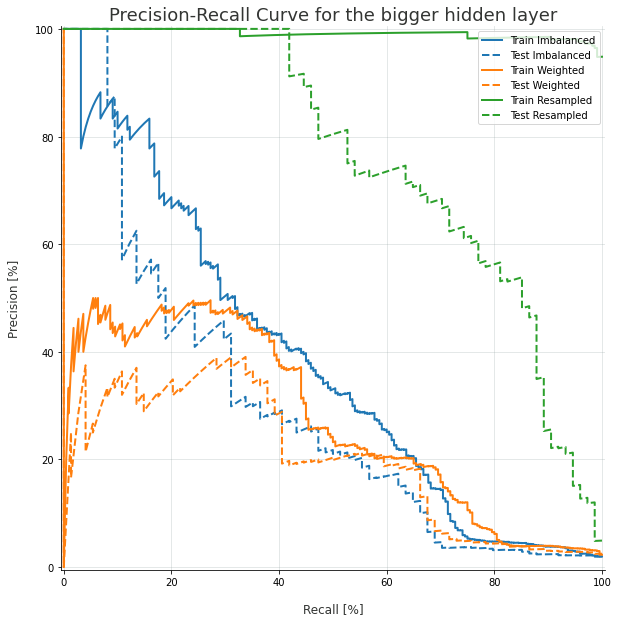

Default model:
loss :  0.06489827483892441
pr_auc :  0.2907923460006714

Weighted model:
loss :  0.6241215467453003
pr_auc :  0.19479691982269287

Resampled model
loss :  0.03788423165678978
pr_auc :  0.7596887350082397



In [0]:
draw_stuff(*nodes256_modesl, "the bigger hidden layer")

#### 256 nodes without dropouts and batchnorm

In [0]:
'''
One hidden layer with 256 nodes, pr-auc, without banchnorm and dropout
'''
def make_model_256_without(output_bias=None):
  metrics = [
             keras.metrics.AUC(curve='PR', name='pr_auc'),
            ]
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
                            keras.layers.Dense(256,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),

                            keras.layers.Dense(1,
                                               activation='sigmoid',
                                               bias_initializer=output_bias),
                            ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

#run_default_weigthed_oversampled(make_model_baseline)

In [0]:
nodes256_wo_modesl = run_default_weigthed_oversampled(make_model_256_without)

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

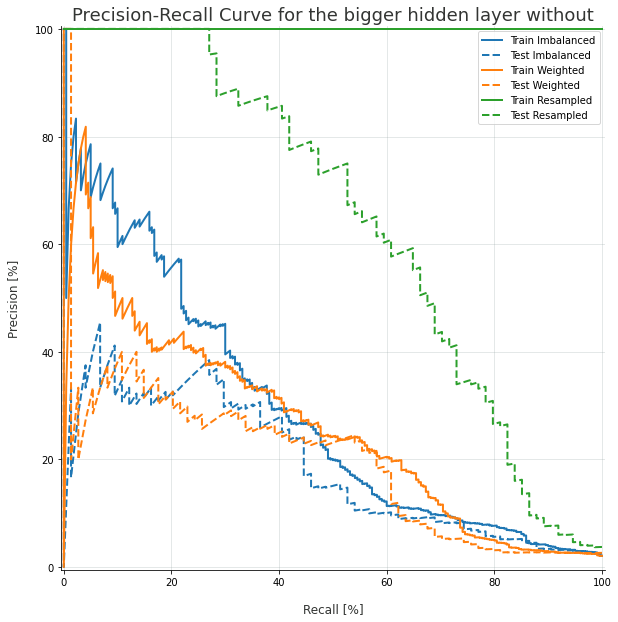

Default model:
loss :  0.06289926171302795
pr_auc :  0.18262580037117004

Weighted model:
loss :  0.47697412967681885
pr_auc :  0.1808125227689743

Resampled model
loss :  0.04207797348499298
pr_auc :  0.637097179889679



In [0]:
draw_stuff(*nodes256_wo_modesl, "the bigger hidden layer without")

#### less hidden nodes

In [0]:
'''
One hidden layer with 16 nodes, pr-auc, without banchnorm and dropout
'''
def make_model_16_without(output_bias=None):
  metrics = [
             keras.metrics.AUC(curve='PR', name='pr_auc'),
            ]
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
                            keras.layers.Dense(8,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),

                            keras.layers.Dense(1,
                                               activation='sigmoid',
                                               bias_initializer=output_bias),
                            ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

#run_default_weigthed_oversampled(make_model_baseline)

In [0]:
nodes16_wo_models = run_default_weigthed_oversampled(make_model_16_without)

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

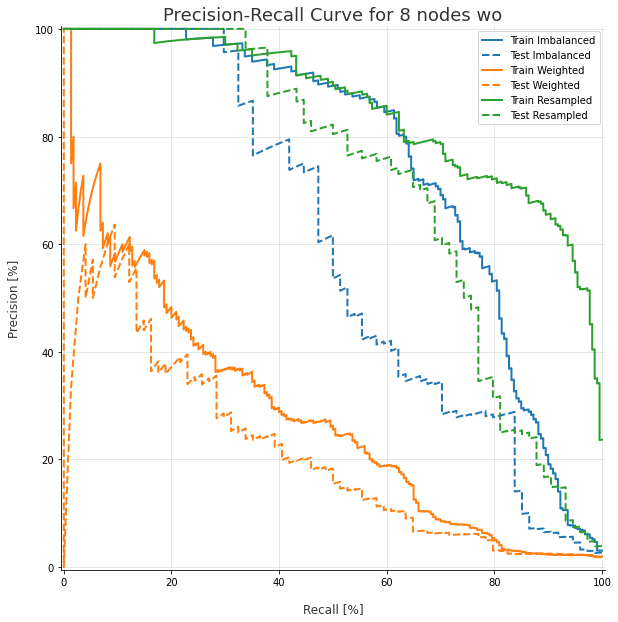

Default model:
loss :  0.045749228447675705
pr_auc :  0.5887303352355957

Weighted model:
loss :  0.4225890040397644
pr_auc :  0.20608927309513092

Resampled model
loss :  0.14553625881671906
pr_auc :  0.713634729385376



In [0]:
draw_stuff(*nodes16_wo_models, "8 nodes wo")

#### two layers

In [0]:
'''
One hidden layer with 16 nodes, pr-auc, without banchnorm and dropout
'''
def make_model_256_32(output_bias=None):
  metrics = [
             keras.metrics.AUC(curve='PR', name='pr_auc'),
            ]
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
                            keras.layers.Dense(512,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.5),

                            keras.layers.Dense(256,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.4),
                            
                            keras.layers.Dense(128,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.3),
                            
                            keras.layers.Dense(32,
                                               activation='relu',
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.2),

                            keras.layers.Dense(1,
                                               activation='sigmoid',
                                               bias_initializer=output_bias),
                            ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

#run_default_weigthed_oversampled(make_model_baseline)

In [0]:
# 512-256-128-32, 0.3
four_layer_04_models = run_default_weigthed_oversampled(make_model_256_32)

Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

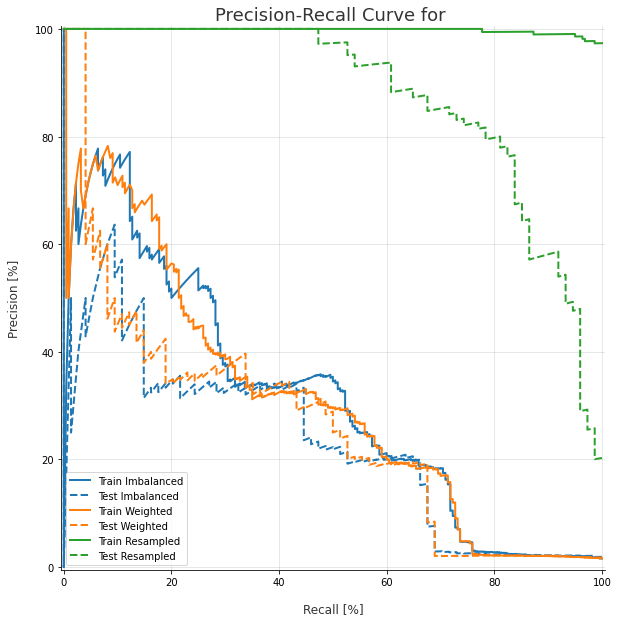

Default model:
loss :  0.2419239580631256
pr_auc :  0.22412222623825073

Weighted model:
loss :  1.4634343385696411
pr_auc :  0.056114278733730316

Resampled model
loss :  0.022196898236870766
pr_auc :  0.859500527381897



In [0]:
draw_stuff(*four_layer_04_models, "")

In [0]:
# 512-256-128-32, 0.3
#three_layer_04_models = run_default_weigthed_oversampled(make_model_256_32)

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

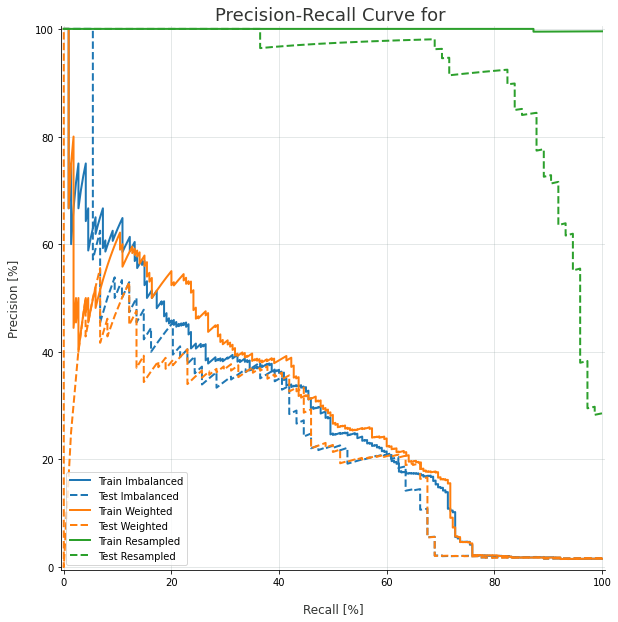

Default model:
loss :  0.09009407460689545
pr_auc :  0.2599523067474365

Weighted model:
loss :  0.8629212975502014
pr_auc :  0.20165051519870758

Resampled model
loss :  0.01650489680469036
pr_auc :  0.9019244313240051



In [0]:
draw_stuff(*three_layer_04_models, "")

In [0]:
# 256-128-32, 0.5
#nodes_256_32_models = run_default_weigthed_oversampled(make_model_256_32)

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versio

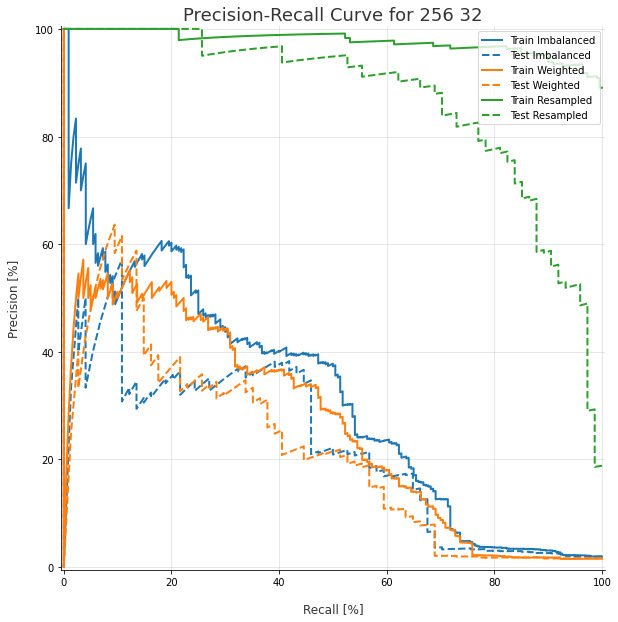

Default model:
loss :  0.0662478432059288
pr_auc :  0.21863512694835663

Weighted model:
loss :  0.1867372691631317
pr_auc :  0.21049799025058746

Resampled model
loss :  0.01872808299958706
pr_auc :  0.8504700660705566



In [0]:
draw_stuff(*nodes_256_32_models, "256 32")

In [0]:
print('meh')

meh


### 4 layers, only resampled,  test different **regularisations**

In [0]:
def make_model_4_layers_dropout(output_bias=None, dropout=0):
  metrics = [
             keras.metrics.AUC(curve='PR', name='pr_auc'),
            ]
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
                            keras.layers.Dense(256,
                                               activation='relu',
                                               input_shape=(train_features.shape[-1],)
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(dropout),
                            
                            keras.layers.Dense(128,
                                               activation='relu',
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(dropout),
                            
                            keras.layers.Dense(32,
                                               activation='relu',
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(dropout),

                            keras.layers.Dense(16,
                                               activation='relu',
                                               ),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(dropout),

                            keras.layers.Dense(1,
                                               activation='sigmoid',
                                               bias_initializer=output_bias),
                            ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [0]:
def run_oversampled(early_stopping=early_stopping_baseline, dropout=0):
  # inital weights
  initial_bias = np.log([pos/neg])
  model = make_model_4_layers_dropout(output_bias = initial_bias, dropout=dropout)
  model.predict(train_features[:10])
  initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
  model.save_weights(initial_weights)
  
  # oversampled
  resampled_model = make_model_4_layers_dropout(dropout=dropout)
  resampled_model.load_weights(initial_weights)

  output_layer = resampled_model.layers[-1] 
  output_layer.bias.assign([0])

  val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
  val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

  resampled_history = resampled_model.fit(
      resampled_ds,
      steps_per_epoch = 20,
      epochs=10*EPOCHS,
      callbacks = [early_stopping],
      validation_data=(val_ds),
      verbose=0)

  return resampled_model

In [0]:
def print_score(resampled_model, dropout=0):
  train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
  test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)


  print("Dropout {}".format(dropout))
  resampled_results = resampled_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
  for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
  print()
  return resampled_results[1]

In [0]:
performances = []

In [0]:
dropouts_range = [0, 0.1, 0.2, 0.3,  0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for dropout_value in dropouts_range:
  model = run_oversampled(dropout=dropout_value)
  performances.append(print_score(model, dropout=dropout_value))

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Dropout 0
loss :  0.03922704979777336
pr_auc :  0.7020313143730164

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Dropout 0.1
loss :  0.02294924110174179
pr_auc :  0.8587217330932617

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Dropout 0.2
loss :  0.02570190094411373
pr_auc :  0.8376756906509399

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Dropout 0.3
loss :  0.024907073006033897
pr_auc :  0.807456374168396

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Dropout 0.4
loss :  0.02984709106385708
pr_auc :  0.786168098449707

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Dropout 0.5
loss :  0.0351128950715065
pr_auc :  0.7957181930541992

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopp

In [0]:
dropouts_range = [0, 0.1, 0.2, 0.3,  0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [0]:
def drow_dropout_performance(performance, dropouts, **kwargs):
  # set design stuff
  ax = plt.subplot(111)#, figsize=(12,12))    
  ax.spines["top"].set_visible(False)   
  ax.spines["right"].set_visible(False)
  plt.grid(True, color="#93a1a1", alpha=0.3)
  ax.set_aspect('equal')
  ax.set_xlabel('Dropout rate', labelpad=15, fontsize=12, color="#333533")
  ax.set_ylabel('Average Precision-Recall AUC', labelpad=15, fontsize=12, color="#333533")
  #ax.set_title("Precision-Recall Curve for {}".format(title), fontsize=18, color="#333533")


  plt.plot(dropouts, performance, linewidth=2, marker='o', **kwargs)


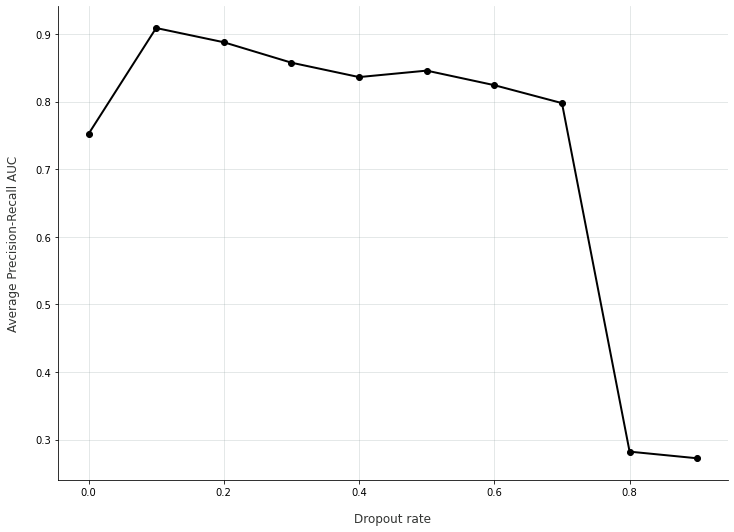

In [0]:
drow_dropout_performance(performances, dropouts_range, color='k')

**Below: old code with separated blocs. Ignore for now**

In [0]:
initial_bias = np.log([pos/neg])
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [0]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

In [0]:

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight) 


In [0]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
  print(label.numpy().mean())


resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

In [0]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

In [0]:
def run_default_weigthed_oversampled(make_model):

  # default
  model = make_model()
  model.load_weights(initial_weights)

  baseline_history = model.fit(
      train_features,
      train_labels,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks = [early_stopping],
      validation_data=(val_features, val_labels))
  
  # weighted
  weighted_model = make_model()
  weighted_model.load_weights(initial_weights)

  weighted_history = weighted_model.fit(
      train_features,
      train_labels,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks = [early_stopping],
      validation_data=(val_features, val_labels),
      class_weight=class_weight) 
  
  # oversampled
  resampled_model = make_model()
  resampled_model.load_weights(initial_weights)

  output_layer = resampled_model.layers[-1] 
  output_layer.bias.assign([0])

  val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
  val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

  resampled_history = resampled_model.fit(
      resampled_ds,
      steps_per_epoch = 20,
      epochs=10*EPOCHS,
      callbacks = [early_stopping],
      validation_data=(val_ds))
  
  # plots
  train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
  test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)
  train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
  test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
  train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
  test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

  plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
  plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

  plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
  plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

  plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
  plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
  plt.legend(loc='lower right')

  plot_pr("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
  plot_pr("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

  plot_pr("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
  plot_pr("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

  plot_pr("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
  plot_pr("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
  plt.legend(loc='upper right')

### Metrics

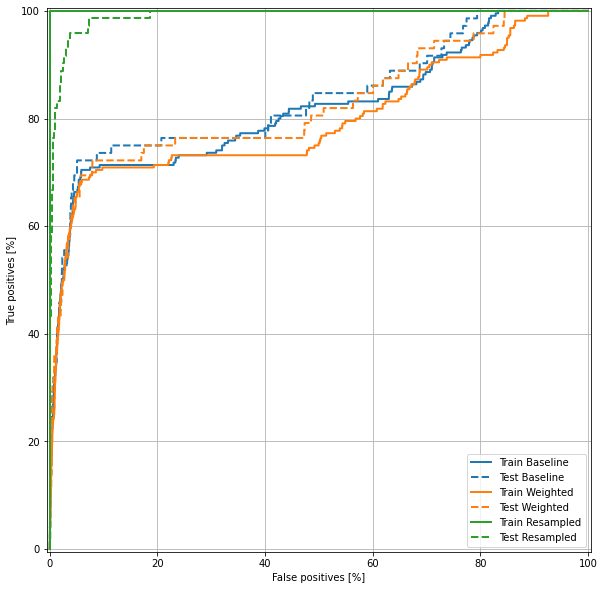

In [0]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

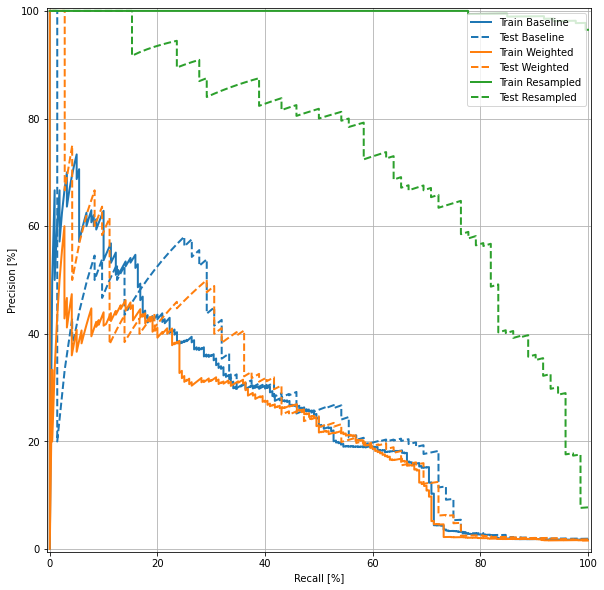

In [0]:
plot_pr("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_pr("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_pr("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_pr("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_pr("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_pr("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='upper right')